# Communicate Data Findings: Ford GoBike
## Data Analyst Nanodegree
- Binh Nguyen
- December 21, 2019

# Table of contents

### <a href="#intro">1. Introduction</a>
### <a href="#download_data">2. Download data</a>
### <a href="#assesing_data">3. Data Exploratory</a>
### <a href="#assesing_data">4. Visualize Data</a>

<a href="#use_rate">1. How the use rate of Ford GoBike?</a>

<a href="#duration">2. What is riding pattern between Customer and Subscriber?</a>

<a href="#riding_pattern">3. What is riding pattern between Customer and Subscriber?</a>

<a href="#time_speed">4. What is duration ride between Customer and Subscriber?<a>
  
<a href="#freq_station">5. Where are most used stations?<a>

### <a href="#summary">5. Summary</a>

<a id="intro"></a>
# 1. Introduction

![ForD GoBike](https://www.voxer.com/blog/wp-content/uploads/2017/08/99bd3_gobike_launch_05.jpg)

- With increasing efforts to provide less-energy intensive and reduce carbon food print, sharing transportion seems a feasible option. Bike sharing in large metropolitans in US aims at the angle. Analyzing data of bike riding patterns provide some insights at data level, and some implications to imporove user experience and system management.

- In this report, we will explore dataset covers the [greater Bay Area](https://s3.amazonaws.com/baywheels-data/index.html) which includes the Downtown San Francisco, East Bay and San Jose . As of January of 2018, there is 2600 bicycles and 262 stations in [this area](https://en.wikipedia.org/wiki/Bay_Wheels). The Ford GoBike was acquired by Lyft and renamed to Bay Wheels in July 2019. 

- The system of bike sharing aims at modern lifestyle with unclok and docking bike with a app on mobile phone. The new ebike design added to system and the "classic" bike is also kept operated [Lyft](https://www.lyft.com/bikes/bay-wheels/meet-our-bikes).

- Other cities has hosted bike-sharing, the available data can be found [here](https://github.com/BetaNYC/Bike-Share-Data-Best-Practices/wiki/Bike-Share-Data-Systems) and [here](https://www.bikeshare.com/data/)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import requests
from bs4 import BeautifulSoup as soup
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('fivethirtyeight')
sns.set_context("notebook", font_scale=1.3)
%matplotlib inline

In [31]:
# https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib

In [3]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

<a id='download_data'></a>
# 2. Download data

## 2.1 Crawl the data files in csv format

In [5]:
# URL contains the data
base_url = 'https://s3.amazonaws.com/baywheels-data'

In [6]:
# get the zip files using html parsing
page = requests.get(base_url)
if page.status_code == 200:
    page_ = soup(page.text)
    links = page_.find_all('key')
    links = [link.text for link in links if 'csv' in link.text]

In [7]:
def make_link(base_, file_):
    return os.path.join(base_, file_)

In [8]:
# make a full http links for downloading
links_full = [make_link(base_url, link) for link in links]
links_full[0]

'https://s3.amazonaws.com/baywheels-data/2017-fordgobike-tripdata.csv'

In [9]:
# this function download cvs.zip to a temporary folder
def download_file(base_dir, tmp_dir, url):
    local_filename = url.split('/')[-1]
    local_filename = os.path.join(base_dir, tmp_dir, local_filename)
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk:
                    f.write(chunk)
    return local_filename

In [16]:
# make a temporary folder
base_dir = '/tmp'
zip_folder = "zipfiles"
csv_folder = 'csv'
zip_f = os.path.join(base_dir, zip_folder)
csv_f = os.path.join(base_dir, csv_folder)
print(zip_f)
if not os.path.isdir(zip_f):
    os.makedirs(zip_f)
    print(f'created folder {zip_f}')
if not os.path.isdir(csv_f):
    os.makedirs(csv_f)
    print(f'created folder {csv_f}')

/tmp/zipfiles
created folder /tmp/zipfiles


In [11]:
# download the cvs file. It will take 10-20 minutes and few hundreds MBs
for link in links_full:
    download_file(base_dir=base_dir,tmp_dir=zip_folder, url=link)
! ls /tmp/zipfiles/

2017-fordgobike-tripdata.csv	    201812-fordgobike-tripdata.csv.zip
201801-fordgobike-tripdata.csv.zip  201901-fordgobike-tripdata.csv.zip
201802-fordgobike-tripdata.csv.zip  201902-fordgobike-tripdata.csv.zip
201803-fordgobike-tripdata.csv.zip  201903-fordgobike-tripdata.csv.zip
201804-fordgobike-tripdata.csv.zip  201904-fordgobike-tripdata.csv.zip
201805-fordgobike-tripdata.csv.zip  201905-baywheels-tripdata.csv.zip
201806-fordgobike-tripdata.csv.zip  201906-baywheels-tripdata.csv.zip
201807-fordgobike-tripdata.csv.zip  201907-baywheels-tripdata.csv.zip
201808-fordgobike-tripdata.csv.zip  201908-baywheels-tripdata.csv.zip
201809-fordgobike-tripdata.csv.zip  201909-baywheels-tripdata.csv.zip
201810-fordgobike-tripdata.csv.zip  201910-baywheels-tripdata.csv.zip
201811-fordgobike-tripdata.csv.zip


The dataset covered from mid 2017 to October 2019

## 2.2 Extract all csv files

In [12]:
from zipfile import ZipFile

In [19]:
# extract all zip files 
for file in os.listdir(os.path.join(base_dir,zip_folder)):
    file = os.path.join(base_dir,zip_folder, file)
    if file.endswith('.csv.zip'):
        with ZipFile(file, 'r') as zipObj:
            zipObj.extractall('/tmp/csv/')

In [20]:
# one csv file in 2017 does not in zip file. I copied it manually
! cp /tmp/zipfiles/2017-fordgobike-tripdata.csv /tmp/csv/ -v

'/tmp/zipfiles/2017-fordgobike-tripdata.csv' -> '/tmp/csv/2017-fordgobike-tripdata.csv'


<a id="explore_data"></a>
# 3. Data Wrangling and Exploratory

In [22]:
# just check the length of all csv files
for file in os.listdir(os.path.join(base_dir,'csv')):
    csv_file = os.path.join(base_dir, 'csv', file)
    if csv_file.endswith('.csv'):
        df = pd.read_csv(csv_file, sep=';')
        print('-'*40)
        print(csv_file)
        print(f'# columns {len(list(df))}')

----------------------------------------
/tmp/csv/201803-fordgobike-tripdata.csv
# columns 14
----------------------------------------
/tmp/csv/201901-fordgobike-tripdata.csv
# columns 14
----------------------------------------
/tmp/csv/201808-fordgobike-tripdata.csv
# columns 14
----------------------------------------
/tmp/csv/201805-fordgobike-tripdata.csv
# columns 14
----------------------------------------
/tmp/csv/201807-fordgobike-tripdata.csv
# columns 14
----------------------------------------
/tmp/csv/201904-fordgobike-tripdata.csv
# columns 14
----------------------------------------
/tmp/csv/201806-fordgobike-tripdata.csv
# columns 14
----------------------------------------
/tmp/csv/201802-fordgobike-tripdata.csv
# columns 14
----------------------------------------
/tmp/csv/201907-baywheels-tripdata.csv
# columns 15
----------------------------------------
/tmp/csv/201908-baywheels-tripdata.csv
# columns 14
----------------------------------------
/tmp/csv/201809-fordg

In [23]:
# not all CSV files have the same number of columns
# drop extra columns that less relevant and make data homogenious
dfs = list()
for file in os.listdir(os.path.join(base_dir,'csv')):
    csv_file = os.path.join(base_dir, 'csv', file)
    if csv_file.endswith('.csv'):
        df = pd.read_csv(csv_file, sep=';')
        if len(list(df)) == 15:
            df.drop(columns = ['bike_share_for_all_trip', 'rental_access_method'], inplace=True)
        if len(list(df)) == 14:
            df.drop(columns ='bike_share_for_all_trip', inplace=True)
        dfs.append(df)

In [24]:
# create a master DataFrame for all loaded df
df = pd.concat(dfs)

In [10]:
# this is a large file
# column structure looks fine
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554806 entries, 0 to 4554805
Data columns (total 13 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
dtypes: float64(6), int64(2), object(5)
memory usage: 451.8+ MB


In [11]:
# about 4.5M rows and 13 columns (after cleaning)
df.shape

(4554806, 13)

In [12]:
# need to sort df by the time
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type
0,424,2017-06-28 09:47:36.347,2017-06-28 09:54:41.187,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,48.0,2nd St at S Park St,37.782411,-122.392706,240,Subscriber
1,366,2017-06-28 09:47:41.664,2017-06-28 09:53:47.715,58.0,Market St at 10th St,37.776619,-122.417385,59.0,S Van Ness Ave at Market St,37.774814,-122.418954,669,Subscriber
2,188,2017-06-28 09:49:46.377,2017-06-28 09:52:55.338,25.0,Howard St at 2nd St,37.787522,-122.397405,48.0,2nd St at S Park St,37.782411,-122.392706,117,Subscriber
3,1201,2017-06-28 09:50:59.175,2017-06-28 10:11:00.359,81.0,Berry St at 4th St,37.775880,-122.393170,9.0,Broadway at Battery St,37.798572,-122.400869,77,Subscriber
4,431,2017-06-28 09:56:39.631,2017-06-28 10:03:51.090,66.0,3rd St at Townsend St,37.778742,-122.392741,321.0,5th at Folsom,37.780146,-122.403071,316,Subscriber


In [28]:
# save file to the local disk just in case
df.to_csv('/tmp/sf_bikeshare.csv', index=False, sep=';')

In [72]:
# reload CSV file if needed
# df = pd.read_csv('/tmp/sf_bikeshare.csv', sep=';')
df = pd.read_csv('/home/bing/Desktop/sf_bikeshare.csv', sep=';')

In [13]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id
count,4.554806e+06,4.484243e+06,4.554806e+06,4.554806e+06,4.482452e+06,4.554806e+06,4.554806e+06,4.554806e+06
mean,8.619804e+02,1.281872e+02,3.776769e+01,-1.223523e+02,1.257575e+02,3.776762e+01,-1.223509e+02,1.273711e+04
std,2.319393e+03,1.096615e+02,1.047017e-01,1.578135e-01,1.091611e+02,1.403899e-01,3.417576e-01,7.428609e+04
min,6.000000e+01,3.000000e+00,0.000000e+00,-1.225143e+02,3.000000e+00,0.000000e+00,-1.225143e+02,1.000000e+01
25%,3.580000e+02,3.700000e+01,3.777041e+01,-1.224117e+02,3.000000e+01,3.777106e+01,-1.224113e+02,1.381000e+03
50%,5.670000e+02,9.200000e+01,3.778101e+01,-1.223983e+02,9.000000e+01,3.778107e+01,-1.223974e+02,2.672000e+03
75%,8.860000e+02,1.970000e+02,3.779539e+01,-1.222934e+02,1.960000e+02,3.779625e+01,-1.222935e+02,4.227000e+03
max,8.636900e+04,4.820000e+02,4.551000e+01,0.000000e+00,4.820000e+02,4.551000e+01,0.000000e+00,9.994220e+05


In [14]:
# seem no duplicated row sofar
df[df.duplicated()]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type


<a id="visual"></a>
#  4. Visualize Data

In [6]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type
0,424,2017-06-28 09:47:36.347,2017-06-28 09:54:41.187,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,48.0,2nd St at S Park St,37.782411,-122.392706,240,Subscriber
1,366,2017-06-28 09:47:41.664,2017-06-28 09:53:47.715,58.0,Market St at 10th St,37.776619,-122.417385,59.0,S Van Ness Ave at Market St,37.774814,-122.418954,669,Subscriber
2,188,2017-06-28 09:49:46.377,2017-06-28 09:52:55.338,25.0,Howard St at 2nd St,37.787522,-122.397405,48.0,2nd St at S Park St,37.782411,-122.392706,117,Subscriber
3,1201,2017-06-28 09:50:59.175,2017-06-28 10:11:00.359,81.0,Berry St at 4th St,37.775880,-122.393170,9.0,Broadway at Battery St,37.798572,-122.400869,77,Subscriber
4,431,2017-06-28 09:56:39.631,2017-06-28 10:03:51.090,66.0,3rd St at Townsend St,37.778742,-122.392741,321.0,5th at Folsom,37.780146,-122.403071,316,Subscriber


In [73]:
# remove row with empty station_id
df = df[~(df.end_station_id.isna() | df.start_station_id.isna())]

In [16]:
df[df.end_station_id.isna()]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type


In [17]:
df.shape

(4468852, 13)

In [74]:
#  convert to datetime object
for var in ['start_time', 'end_time']:
    df[var] = pd.to_datetime(df[var])

In [75]:
df.sort_values('start_time', inplace=True)

In [76]:
# group some key datetime objects for further analysis
df['m'] = df.start_time.apply(lambda x: x.month)
df['m-y'] = df.start_time.apply(lambda x: f'{x.month}-{x.year}')
df['d'] = df.start_time.apply(lambda x: x.date())

In [68]:
for var in ['start_station_id', 'end_station_id']:
    df[var] = df[var].astype(int)

In [22]:
df.dtypes

duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                    int64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                      int64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                             int64
user_type                          object
m                                   int64
m-y                                object
d                                  object
dtype: object

In [23]:
df.start_station_id.nunique()

425

In [24]:
df.bike_id.nunique()

11557

In [71]:
df.user_type.unique()

array(['Subscriber', 'Customer'], dtype=object)

In [77]:
user_class = pd.api.types.CategoricalDtype(ordered=True, categories= df.user_type.unique())
df['user_type'] = df['user_type'].astype(user_class)

In [4]:
# df.to_csv('/tmp/sf_bikeshare_1.csv', index=False, sep=';')
df = pd.read_csv('/tmp/sf_bikeshare_1.csv', sep=';')

In [15]:
df[df.end_station_id.isna() ]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,m,m-y,d


In [39]:
df[df.bike_id.isna()].shape

(0, 13)

In [16]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,m
count,4.468852e+06,4.468852e+06,4.468852e+06,4.468852e+06,4.468852e+06,4.468852e+06,4.468852e+06,4.468852e+06,4.468852e+06
mean,8.597963e+02,1.280617e+02,3.776964e+01,-1.223545e+02,1.256500e+02,3.776956e+01,-1.223531e+02,5.158544e+03,6.615044e+00
std,2.319863e+03,1.095758e+02,1.006432e-01,1.381410e-01,1.090939e+02,1.379971e-01,3.357808e-01,3.372167e+04,3.155112e+00
min,6.000000e+01,3.000000e+00,0.000000e+00,-1.224952e+02,3.000000e+00,0.000000e+00,-1.224952e+02,1.000000e+01,1.000000e+00
25%,3.570000e+02,3.700000e+01,3.777106e+01,-1.224117e+02,3.000000e+01,3.777106e+01,-1.224113e+02,1.352000e+03,4.000000e+00
50%,5.660000e+02,9.100000e+01,3.778107e+01,-1.223983e+02,9.000000e+01,3.778107e+01,-1.223974e+02,2.627000e+03,7.000000e+00
75%,8.830000e+02,1.970000e+02,3.779539e+01,-1.222948e+02,1.960000e+02,3.779625e+01,-1.222948e+02,3.979000e+03,9.000000e+00
max,8.636900e+04,4.820000e+02,4.551000e+01,0.000000e+00,4.820000e+02,4.551000e+01,0.000000e+00,9.984300e+05,1.200000e+01


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4468852 entries, 0 to 4554805
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           int64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             int64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
m                          int64
m-y                        object
d                          object
dtypes: datetime64[ns](2), float64(4), int64(5), object(5)
memory usage: 579.6+ MB


**Data structure:**
- About 4.5M rows and 13 columns
- Information included: using duration, start and end time, station name, id, coordinates, user type and bike id

**Interested questions**

- What is the use rate of each bike? This could help to determine if more bike is needed, and show a clear pattern of use rate?
- What the difference and similar of Customer and Subscriber riding patterns? The outcome helps nagivate the two class of customer and on the price model
- Where is most used location? This is useful to place the docking station for bikes

<a id="use_rate"></a>
## 1. How the use rate of Ford GoBike?

In [80]:
# convert a string object to a datetime and reindex
def fmt_df(df):
    df.index = pd.to_datetime(df.index, format='%m-%Y')
    df.sort_index(inplace=True)
    return df

In [81]:
# make the axis count more readable
def transform_axis_fmt(tick_val, pos):
    if tick_val <1_000:
        return int(tick_val)
    elif tick_val < 1_000_000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    else:
        val = int(tick_val/1_000_000)
        return '{:d}M'.format(val)

In [28]:
 # let count numeber of rides by month and sort by index
rides = df.groupby('m-y').size()
rides = fmt_df(rides)

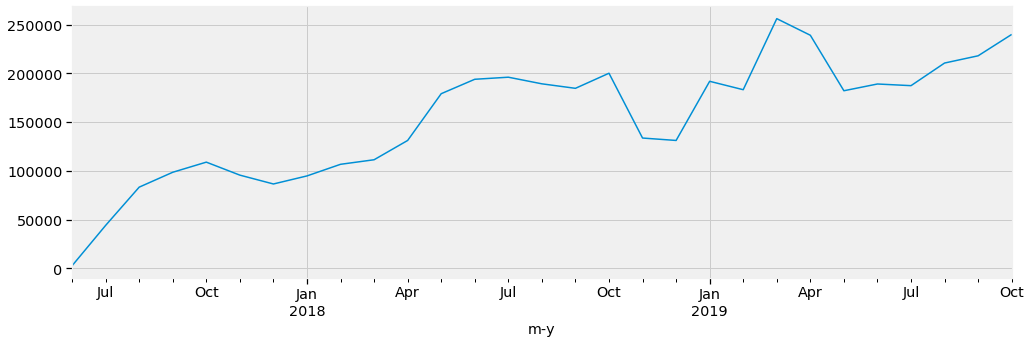

In [29]:
# a quick look
rides.plot(kind='line');

In [30]:
# and also number of bikes by month
bikes = df.groupby('m-y').bike_id.nunique()
bikes = fmt_df(bikes)

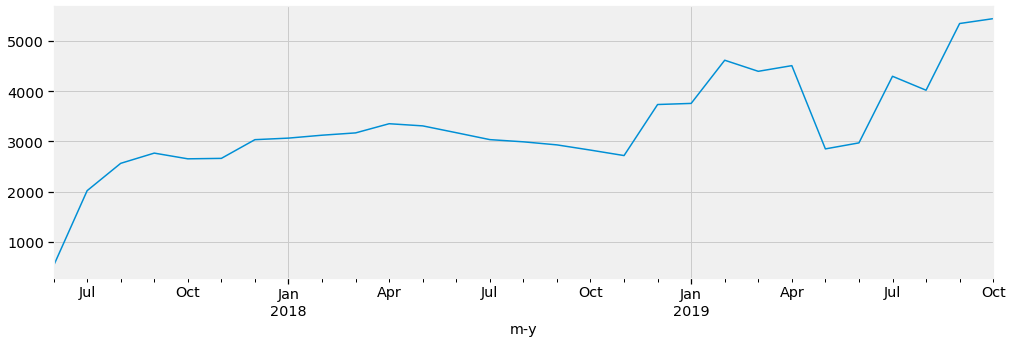

In [31]:
bikes.plot(kind='line');

In [32]:
# also, number of rides per bike per month show the use rate
ride_df = rides.copy(deep=True)
ride_df = ride_df.divide(bikes);

In [46]:
# additional imports to make the graphs look betters
import matplotlib.ticker as tick

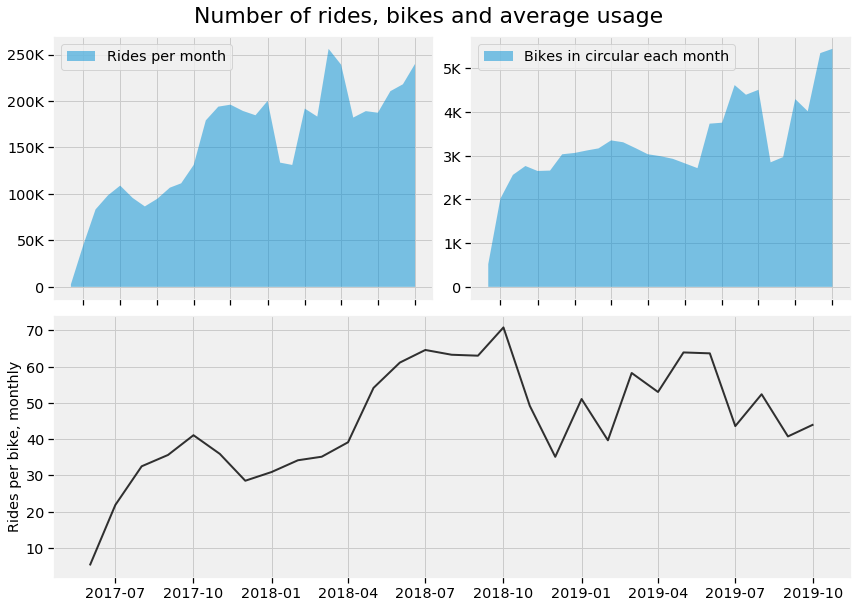

In [34]:
fig = plt.figure(figsize=(12, 12))
gridsize = (3, 2)
fig.suptitle('Number of rides, bikes and average usage', y=0.70, fontsize=22) 

ax1 = plt.subplot2grid(gridsize, (1, 0))
ax1.xaxis.set_ticklabels([])
ax1.stackplot(rides.index, rides.values, alpha=0.5)
ax1.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
ax1.legend(labels=['Rides per month'], loc='upper left')

ax2 = plt.subplot2grid(gridsize, (1, 1))
ax2.xaxis.set_ticklabels([])
ax2.stackplot(bikes.index, bikes.values, alpha=0.5)
ax2.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
ax2.legend(labels=['Bikes in circular each month'], loc='upper left')


ax3 = plt.subplot2grid(gridsize, (2, 0), colspan=2, rowspan=2)
plt.plot(ride_df.index, ride_df.values, alpha=0.8, c='black', linewidth=2);
ax3.set_ylabel('Rides per bike, monthly')
plt.tight_layout()

- Adoption rates shot up quickly around July- June 2017
- Summer time in SF has a higher use rate in compared the the winter in the same year

<a id="duration"></a>
## 2. What is duration ride between Customer and Subscriber?

In [35]:
# make the axis count more readable
def transform_axis_fmt_time(tick_val, pos):
    if tick_val <60:
        return tick_val
    elif tick_val < 3_600:
        val = tick_val/60
        return '{:.0f}m'.format(val)
    else:
        val = tick_val/3_600
        return '{:.0f}h'.format(val)

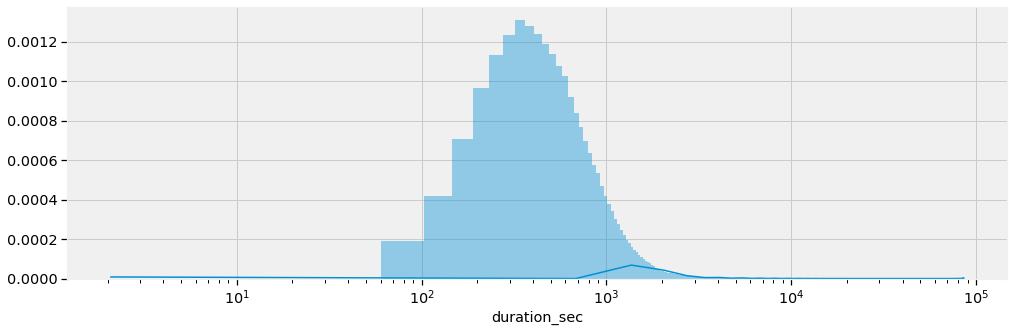

In [36]:
# and distribution, 2000 bins is not very practical
ax = sns.distplot(df.duration_sec, bins=2000)
plt.xscale('log');

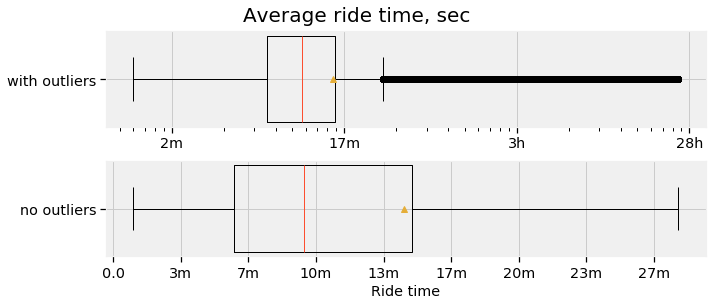

In [37]:
# let have a look at the average ride time
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(10,4), )
fig.suptitle('Average ride time, sec', y=1.05, fontsize=20) 

ax1.boxplot(x=df.duration_sec, vert=False, widths=10, showmeans=True)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt_time))
ax1.set_yticklabels(['with outliers']);

ax2.boxplot(x=df.duration_sec, vert=False, widths=10, showmeans=True, showfliers=False)
ax2.set_yticklabels(['no outliers']);
ax2.xaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt_time))
ax2.set_xlabel('Ride time');
plt.tight_layout()

In [38]:
# let check the range of duration
stats = df.duration_sec.describe()

In [39]:
# check mean and median
print(f'Mean: {stats["mean"]/60:.0f}; Median: {stats["50%"]/60:.0f}')

Mean: 14; Median: 9


- On average, riders use the bike for 14 minutes, and 50% of riders uses the bike less than 9 minutes (*or the other 50% uses the bike for more than 9 minutes*)
- On average, Customer and Subscriber use the bike less than 10 minutes. This is smaller than 30-min ride for Customer and 45-min ride allowance. Extra minutes is accepted with different [pricing](https://www.lyft.com/bikes/bay-wheels/pricing)

let get the mean by sns [plot](https://stackoverflow.com/questions/54376452/how-can-i-determine-and-remove-outliers-found-by-boxplot-in-python)

In [40]:
# get stats summary without outliers by 1.5IQR (match seaborn boxplot)
def get_stats(df, col_name='duration_sec'):
    Q1 =  df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    stats = df[(df[col_name] > Q1-1.5*IQR ) | (df[col_name] < Q3+1.5*IQR)][col_name].describe()
    return stats

In [41]:
stats_c = get_stats(df.query("user_type=='Customer'"))
stats_s = get_stats(df.query("user_type=='Subscriber'"))

In [42]:
s_text = f'Minutes\nMean: {stats_s["mean"]/60:.0f} \nMedian: {stats_s["50%"]/60:.0f}'

In [43]:
c_text = f'Minutes\nMean: {stats_c["mean"]/60:.0f} \nMedian: {stats_c["50%"]/60:.0f}'

In [44]:
# bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="white", lw=2)
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8)

In [45]:
base_color = sns.color_palette()[0]

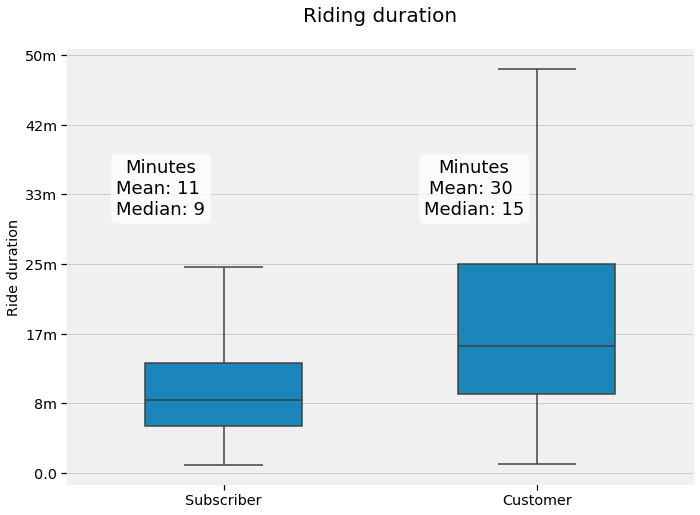

In [46]:
# and how Customer and Subscriber ride duration looks like?
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(data=df, x='user_type', y='duration_sec', 
                 color=base_color,showfliers=False,
                width=0.5)
ax.set_title('Riding duration', fontsize=20, y=1.05)
ax.set_xlabel('')
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt_time))
ax.set_ylabel('Ride duration');
plt.annotate(s_text, xy=(-.2, 17*2*60), xycoords="data", bbox=bbox_props, size=18, ha="center", va="center");
plt.annotate(c_text, xy=(0.8, 17*2*60), xycoords="data", bbox=bbox_props, size=18, ha="center", va="center");

- On average, Subsribers rode bikes less time than Customers
- Averege duration time for Subsriber is ~11 minutes/trip, Customers was ~30 minutes/trip
- 50% of Subsribers rode bikes less than 9 minutes/trip, 50% of Customers was ~30 minutes/trip

In [67]:
df.head()

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,m,h,dofw,distance,speed
duration_sec,,,,,,,,,,,,
66198,285.0,37.783521,-122.431158,55.0,37.777053,-122.429558,2186.0,8.0,18.0,3.0,0.733060,0.039865
66209,30.0,37.776598,-122.395282,6.0,37.804770,-122.403234,3343.0,7.0,18.0,2.0,3.210578,0.174570
66243,107.0,37.763015,-122.426497,355.0,37.755367,-122.388795,3392.0,9.0,17.0,5.0,3.422794,0.186013
66247,93.0,37.770407,-122.391198,92.0,37.772301,-122.393028,2790.0,5.0,15.0,6.0,0.264971,0.014399
66259,377.0,37.771917,-122.453704,377.0,37.771917,-122.453704,1488.0,2.0,15.0,6.0,0.000000,0.000000


In [82]:
# on first look, Customer seems to be a better target ridership
# let look one level deeper
users = df.groupby(['m-y', 'user_type']).size()
users = users.reset_index(name='size')
users = users.pivot(index='m-y', columns='user_type', values='size')
users = fmt_df(users)

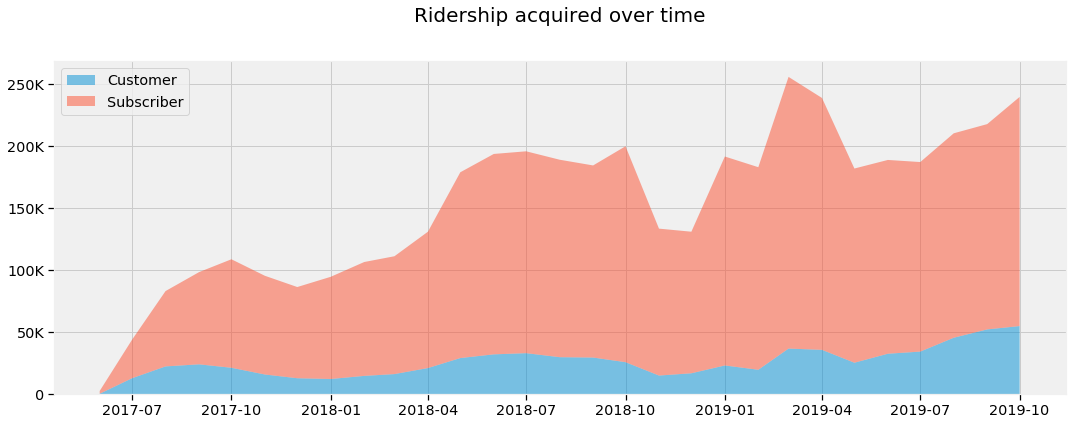

In [85]:
# let look at number of Customer and Subsriber over time
plt.figure(figsize=(15,6))
plt.stackplot(users.index, users.Customer, users.Subscriber, alpha=0.5)
plt.title("Ridership acquired over time", fontsize=20, y=1.1)
plt.legend(['Customer', 'Subscriber'], loc='upper left')
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.tight_layout()

In [89]:
# The system has more Subsribers and they rode less than Customers
# let look at the total ride duration of each class
dfsum = df.groupby(['d', 'user_type']).duration_sec.sum().reset_index(name='sum')
dfsum = dfsum.pivot(index='d', columns='user_type', values='sum')

In [90]:
dfsum.index = pd.to_datetime(dfsum.index)
# this looks at weekly rolling average
ma = dfsum.rolling('7d').mean()

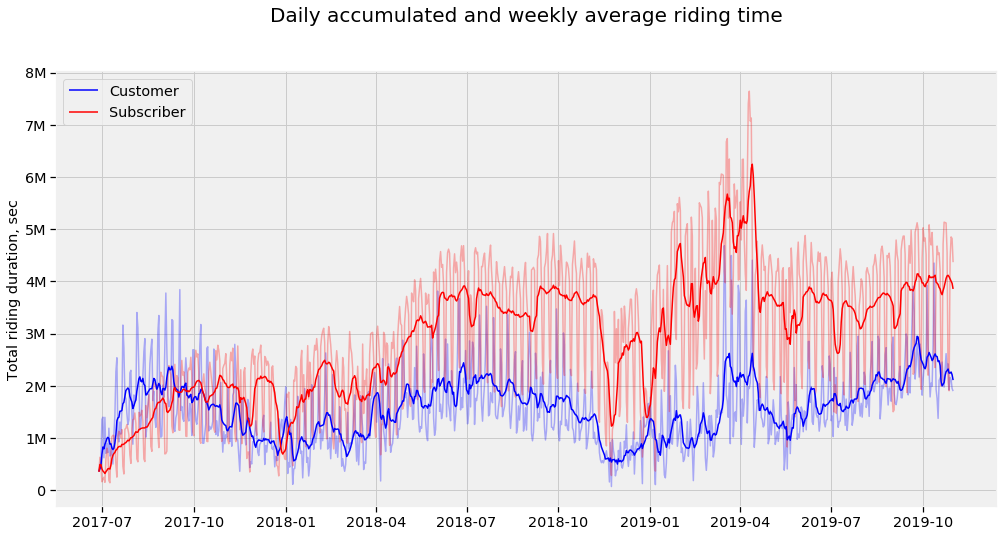

In [91]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title("Daily accumulated and weekly average riding time", fontsize=20, y=1.1)
ax.plot(dfsum.index, dfsum.Customer, alpha=0.3, c='blue')
ax.plot(dfsum.index, dfsum.Subscriber, alpha=0.3, c='red')
ax.plot(ma.index, ma.Customer, label='Customer', c='blue')
ax.plot(ma.index, ma.Subscriber, label='Subscriber',c='red' )
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
ax.legend(loc="upper left")
ax.set_ylabel('Total riding duration, sec');
# plt.yscale('log')

- interesting! based on [0pricing model](https://www.lyft.com/bikes/bay-wheels/pricing), Customer paid \\$2 for 30-minute ride and Subscriber paid \$15 for 45-minute ride unlimited.
- Ford GoBike adopted by Customer at the early state which suggests the membership was not fully rolled out
- the total ride time of Subscribers are higher than Customers after early stage

In [52]:
del dfsum

<a id="riding_pattern"></a>
## 3. What is riding pattern between Customer and Subscriber?

In [54]:
# let group hour and day in week to travel riding pattern
df['h'] = df.start_time.apply(lambda x: x.hour)
df['dofw'] = df.start_time.apply(lambda x: x.weekday())

In [49]:
xticks = ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su']

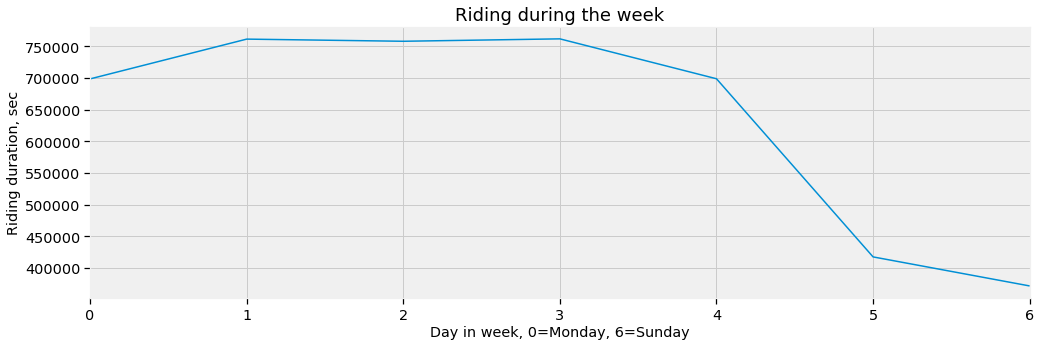

In [68]:
# a quick look at number of rides in each day of weeks
# 0 = Monday, 6= Sunday
ax = df.groupby('dofw').size().plot(kind='line')
plt.xlabel("Day in week, 0=Monday, 6=Sunday")
plt.ylabel("Riding duration, sec")
plt.title("Riding during the week", fontsize=18);

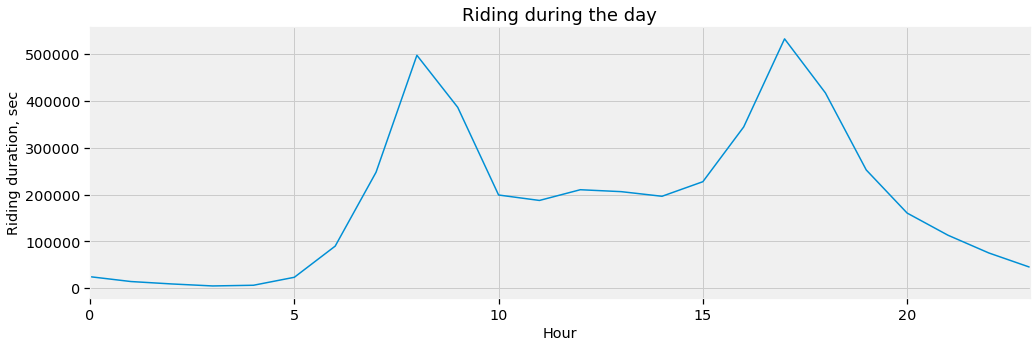

In [69]:
# and during the day. It makes sense the bikes were used 
# for short commutes
ax = df.groupby('h').size().plot(kind='line');
plt.xlabel("Hour")
plt.ylabel("Riding duration, sec")
plt.title("Riding during the day", fontsize=18);

In [121]:
# let looks close to each class of Customer and Subsriber
dfc = df.query('user_type=="Customer"')
dfs = df.query('user_type=="Subscriber"')

In [122]:
# customer
var = 'dofw'
df_extract = dfc.groupby(['h', var]).size().reset_index(name='size')
dfcc = df_extract.pivot(index='h', columns=var, values='size')

In [123]:
# subscriber
var = 'dofw'
df_extract = dfs.groupby(['h', var]).size().reset_index(name='size')
dfss = df_extract.pivot(index='h', columns=var, values='size')

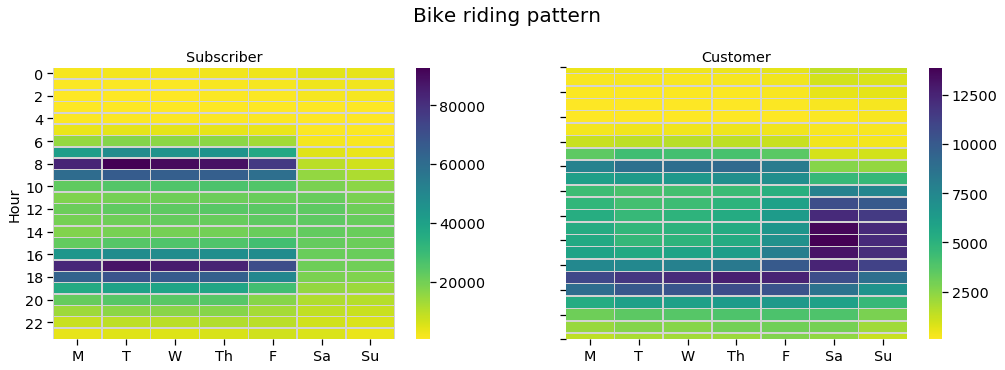

In [126]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle('Bike riding pattern',y=1.05, fontsize=20)
ax1.set_title('Subscriber')
sns.heatmap(ax=ax1, data=dfss, cmap='viridis_r', 
            linewidth=0.5, linecolor='lightgray', xticklabels=xticks)
plt.sca(ax1)
plt.yticks(rotation=0)

ax2.set_title('Customer')
sns.heatmap(ax=ax2, data=dfcc, cmap='viridis_r', 
            linewidth=0.5, linecolor='lightgray', xticklabels=xticks)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax1.set_xlabel('')
ax1.set_ylabel('Hour');

- Subsriber used bike for commutes
- Customers used bike for some commute, but mostly for visiting and pleasure in the weekends
- There are about 6 times more rides by Subscriber than Customers with the same color tone

In [131]:
# prevent out of memory
del dfc
del dfs

<a id="time_speed"></a>
## 4. What is riding distance and speed  between Customer and Subscriber?

In [5]:
from math import sin, cos, sqrt, atan2, radians

In [6]:
# calculate distance by coordinates
R = 6373.0
def cal_distance(pos1=None, pos2=None):
    if isinstance(pos1, tuple) and isinstance(pos1, tuple):
        lat1, lon1 = pos1
        lat2, lon2 = pos2
        lat1 = radians(abs(lat1))
        lon1 = radians(abs(lon1))
        lat2 = radians(abs(lat2))
        lon2 = radians(abs(lon2))
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        return distance
    else:
        print('Latitude and longtide is not in tuple. Exit.')
        exit()

In [7]:
df['distance'] = df.apply(lambda row: cal_distance((row.start_station_latitude, row.start_station_longitude),
                                       (row.end_station_latitude, row.end_station_longitude)), axis=1)

In [8]:
df['speed'] = df.distance/(df.duration_sec/3600)

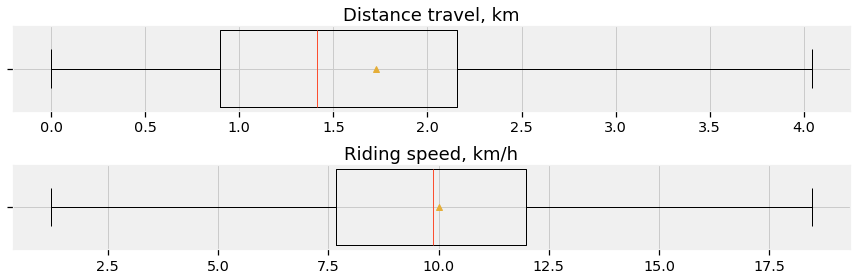

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,4))
ax1.set_title('Distance travel, km', fontsize=18);
ax1.boxplot(x=df.distance, vert=False, widths=8, showmeans=True, showfliers=False);
ax1.set_yticklabels([]);

ax2.set_title('Riding speed, km/h', fontsize=18);
ax2.boxplot(x=df.speed, vert=False, widths=10, showmeans=True, showfliers=False);
ax2.set_yticklabels([]);
plt.tight_layout()

In [135]:
stats = get_stats(df, col_name='distance')
print(stats['mean'], stats['50%'])

1.7273009738458267 1.4124255594677495


In [137]:
stats = get_stats(df, col_name='speed')
print(stats['mean'], stats['50%'])

10.00595437285613 9.86509460407527


In [142]:
# a few trip seems don't make sense, this could be, but only in a few
df[df.speed > 50].shape

(31, 20)

In [143]:
data = {'Subscriber_dist': df.query("user_type=='Subscriber'").distance.describe(),
       'Customer_dist': df.query("user_type=='Customer'").distance.describe(),
        'Subscriber_speed': df.query("user_type=='Subscriber'").speed.describe(),
       'Customer_speed': df.query("user_type=='Customer'").speed.describe()
       }

In [144]:

pd.DataFrame(data=data)

,Subscriber_dist,Customer_dist,Subscriber_speed,Customer_speed
count,3.719888e+06,748964.000000,3.719888e+06,748964.000000
mean,1.690487e+00,1.910145,1.054638e+01,7.321831
std,2.968701e+01,46.777387,2.523670e+02,120.390936
min,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,8.860427e-01,0.959551,8.250471e+00,3.948784
50%,1.391528e+00,1.544763,1.021348e+01,7.395233
75%,2.105861e+00,2.366189,1.225912e+01,10.029885
max,1.280236e+04,12802.364548,2.632576e+05,60325.156306


- Average riding distance was about 1.7km, with 50% riders traveled less than 1.4km.
- Subscribers rode on average 1.7 km/trip, Customers was 1.9 km/trip
- Subscribers rode on average 10 km/h, Customers was 7.3 km/h

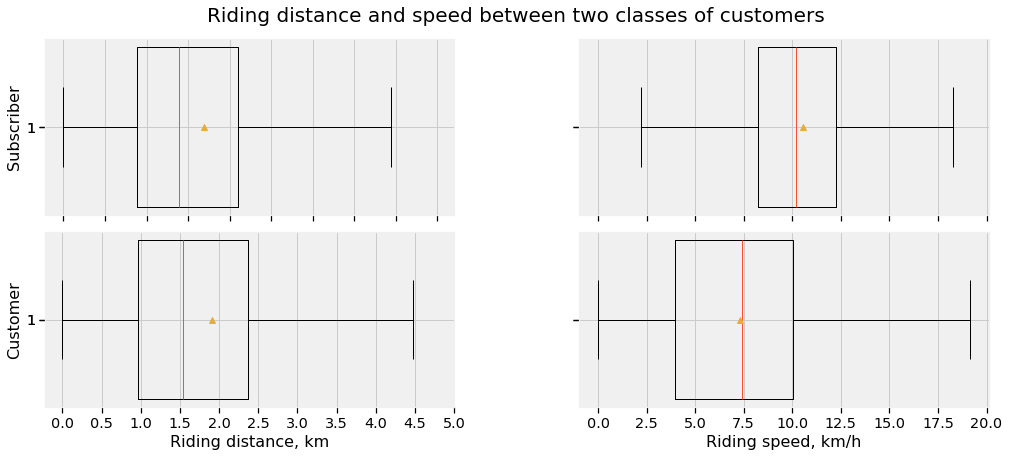

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,6), sharex='col', sharey='row')
plt.subplots_adjust(wspace=20, hspace=0.2)
distance = np.arange(0, 5.1, 0.5)
plt.suptitle('Riding distance and speed between two classes of customers', y=1.05, fontsize=20)
axes[0,0].set_ylabel('Subscriber', fontsize=16)

axes[0,0].boxplot(x=df.query("user_type=='Subscriber'").distance, vert=False, 
                  widths=5, showmeans=True, showfliers=False);


axes[1,0].set_ylabel('Customer', fontsize=16)
axes[1,0].boxplot(x=df.query("user_type=='Customer'").distance, vert=False, 
                  widths=5, showmeans=True, showfliers=False);

axes[0,1].boxplot(x=df.query("user_type=='Subscriber'").speed, vert=False, 
                  widths=5, showmeans=True, showfliers=False);


axes[1,1].boxplot(x=df.query("user_type=='Customer'").speed, vert=False,
                  widths=5, showmeans=True, showfliers=False);
axes[1,0].set_xticks(distance)
axes[1,0].set_xlabel('Riding distance, km', fontsize=16);
axes[1,1].set_xlabel('Riding speed, km/h', fontsize=16);
plt.tight_layout();

- Customers traveled farther, but only in small margin
- Subscribers rode bike faster. They used the bike for commute, so the route was charted out
- Customers rode bike for pleasure which the speed about 25% slower

<a id="freq_station"></a>
## 5. Where are most used stations?

In [58]:
# let define the box for Downtown San Francisco
BBox = (-122.5152,   -122.3535,
       37.8113, 37.7003)

In [59]:
# and filter out by the coordinate
df = df[(df.start_station_latitude < BBox[2]) & (df.end_station_latitude > BBox[3]) &
   (df.start_station_longitude > BBox[0]) & (df.start_station_longitude < BBox[1])]

In [60]:
import gmaps

In [61]:
with open('/home/yourname/.apikey.txt') as f:
    api_key = f.readline()

In [62]:
figure_layout = {
'width': '600px',
'height': '600px',
'border': '1px solid black',
'padding': '1px'}

In [63]:
gmaps.configure(api_key=api_key)
gmaps.figure(map_type='TERRAIN');

In [64]:
df = df.groupby('duration_sec').mean().sort_values('duration_sec').tail(1000)

In [65]:
df3 = df[['start_station_latitude', 'start_station_longitude']]
df4 = df[['end_station_latitude', 'end_station_longitude']]

In [66]:
layer_1 = gmaps.symbol_layer(
    df3,
    fill_color='rgba(150,0,0,0)',
    stroke_color='rgba(150,0,0,0.1)',
    scale=4,
)
layer_2 = gmaps.symbol_layer(
    df4,
    fill_color='rgba(0,0,150,0)',
    stroke_color='rgba(0,0,150,1)',
    scale=2,
)
fig = gmaps.figure(layout=figure_layout,map_type='TERRAIN')
fig.add_layer(layer_1)
fig.add_layer(layer_2)
fig
# red circle indicate the starting station, in inner blue fill indicates the end station

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='1px', width='600px'))

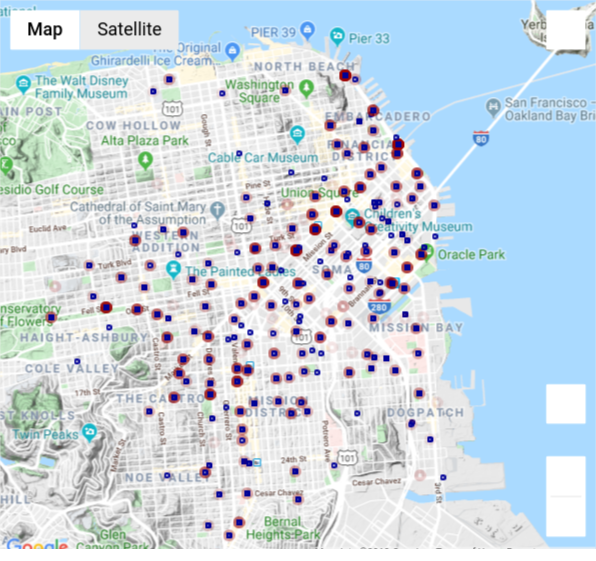

- Most of visited stations are on Market St., which also have a Metro. This suggests the riders used system for commute
- Some stations are around the shoreline near the Bay which suggests using bikes for visiting and pleasure
- End stations (small circle in blue) are more spread out which suggests the riders ended the uplanned such as for exploring and visiting rather than commuting

<a id="summary"></a>
# 5. Summary

1. Riders used the bike more on summers than in the winter in the same year

2. Customer used the bike during the weekends, and Subscribers on on the commute time during weekdays

3. The aggregate ride time of the Subscriber is more than Custommer. 

4. On average, the riders travels about 1.5 km per trip and about 8 km/h

5. The most visited stations placed along the Metro and some near the shoreline by the Bay. This make sense that the bikes were used for a short commute and for pleasure